In [1]:
# IMPORTS

import numpy as np
from glob import glob
import noisereduce as nr
import random
import librosa.display
import IPython
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as k
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping


2022-12-07 11:29:38.493619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# DIRECTORY CONTAINING PREPROCESSED KICK SPECTROGRAMS
data_dir = '/Volumes/CE_CADDY/TRAINING_SAMPLES/Snares_Preprocessed_0.5s'

In [3]:
# FUNCTIONS

## LOAD DATA
def load_data(path):
    X = []
    
    audiofiles = glob(data_dir + '/*.wav.npy')
    
    for file in audiofiles:
        
        X.append(np.load(file))
        
        
    return np.array(X)

## REMOVE NANS FROM DATA
def remove_nans(data):
    if np.isnan(data).sum() > 0:
        a = data.shape[1]
        b = data.shape[2]
        good_data_total = int(data.shape[0] - (np.isnan(data).sum() / (a * b)))
        data = data[~np.isnan(data)]
        data = data.reshape(good_data_total, a,b)
        return data
    return data

## POST-PROCESS AND PLAY GENERATED SPECTROGRAMS
def postproc_and_play_snare(generated_spectrogram):
    #sample rate
    sr = 32000
    # random value to pitch down sample
    pdown = random.uniform(-30, -16)
    # spectrogram back to audio
    new_snare = librosa.griffinlim(generated_spectrogram, n_iter=256, hop_length=300)
    # noise reduction on audio
    new_snare_nr = nr.reduce_noise(y=new_snare, sr=sr, stationary=True)
    # pitch down audio by random amount
    new_snare_final = librosa.effects.pitch_shift(new_snare_nr, sr=sr, n_steps = pdown, bins_per_octave=16, res_type='kaiser_best')
    # display waveform and return player for audio file
    librosa.display.waveshow(new_snare_final,sr=sr)
    return IPython.display.Audio(new_snare_final, rate=sr)

In [4]:
# LOAD DATA
data = load_data(data_dir)

In [5]:
# CHECK DATA SHAPE BEFORE REMOVING NANS
data.shape

(6059, 256, 94)

In [6]:
# CHECK NANS IN DATA
np.isnan(data).sum()

96256

In [7]:
# REMOVE NANS
data = remove_nans(data)

In [8]:
data.shape

(6055, 256, 94)

In [9]:
# CREATE TRAINING AND VALIDATION SETS
X_train = data[:5000, :, :]
X_valid = data[5000:5850, :, :]

Sampling layer which is called later in the function, takes in mean and log_var and randomly samples the coding from normal distribution.

In [10]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return k.random_normal(tf.shape(log_var)) * k.exp(log_var/2) + mean

In [11]:
codings_size = 32

encoder, mean and log_var take in same input from second layer hense not being sequential

In [12]:
w = data.shape[1]
h = data.shape[2]

In [13]:
w

256

In [14]:
h

94

In [15]:
inputs = layers.Input(shape=[w,h])
z = layers.Flatten()(inputs)
z = layers.Dense(500, activation='relu')(z)
z = layers.Dense(300, activation='relu')(z)
z = layers.Dense(150, activation='selu')(z)
z = layers.Dense(100, activation='selu')(z)
codings_mean = layers.Dense(codings_size)(z)
codings_log_var = layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean,codings_log_var])
variational_encoder = Model(
inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

2022-12-07 11:29:48.015403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


decoder

In [16]:
decoder_inputs = layers.Input(shape=[codings_size])
x = layers.Dense(100, activation='selu')(decoder_inputs)
x = layers.Dense(150, activation='selu')(x)
x = layers.Dense(300, activation='relu')(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dense(w * h, activation='sigmoid')(x)
outputs = layers.Reshape([w, h])(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

In [17]:
_,_,codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

In [18]:
latent_loss = -0.5 * k.sum(
1 + codings_log_var - k.exp(codings_log_var) - k.square(codings_mean),
axis=-1)
variational_ae.add_loss(k.mean(latent_loss)/w*h)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [19]:
# variational_ae.summary()

In [20]:
# SOME VARIABLES FOR GENERATION
hop_length = 300
win_length = 1200
sr = 48000
s_devs = 3

In [21]:
es = EarlyStopping(patience=32,restore_best_weights=True)

history = variational_ae.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=[X_valid, X_valid], callbacks=[es])

Epoch 1/100
40/40 [==============================] - 16s 364ms/step - loss: 31776508812984320.0000 - val_loss: 8.7368
Epoch 2/100
40/40 [==============================] - 14s 349ms/step - loss: 5.7669 - val_loss: 4.1133
Epoch 3/100
40/40 [==============================] - 14s 345ms/step - loss: 4.2103 - val_loss: 3.9643
Epoch 4/100
40/40 [==============================] - 14s 350ms/step - loss: 3.3125 - val_loss: 2.9253
Epoch 5/100
40/40 [==============================] - 14s 355ms/step - loss: 2.6494 - val_loss: 4.6293
Epoch 6/100
40/40 [==============================] - 14s 352ms/step - loss: 2.0832 - val_loss: 5.3941
Epoch 7/100
40/40 [==============================] - 14s 355ms/step - loss: 1.7537 - val_loss: 1.7066
Epoch 8/100
40/40 [==============================] - 14s 354ms/step - loss: 1.6034 - val_loss: 1.2147
Epoch 9/100
40/40 [==============================] - 13s 329ms/step - loss: 1.4628 - val_loss: 0.9723
Epoch 10/100
40/40 [==============================] - 14s 354ms/st

40/40 [==============================] - 14s 340ms/step - loss: 0.3029 - val_loss: 0.3830
Epoch 81/100
40/40 [==============================] - 13s 330ms/step - loss: 0.3027 - val_loss: 0.3958
Epoch 82/100
40/40 [==============================] - 14s 351ms/step - loss: 0.3029 - val_loss: 0.3883
Epoch 83/100
40/40 [==============================] - 14s 353ms/step - loss: 0.3025 - val_loss: 0.3990
Epoch 84/100
40/40 [==============================] - 15s 379ms/step - loss: 0.3028 - val_loss: 0.3821
Epoch 85/100
40/40 [==============================] - 15s 366ms/step - loss: 0.3027 - val_loss: 0.3943
Epoch 86/100
40/40 [==============================] - 15s 365ms/step - loss: 0.3026 - val_loss: 0.3856
Epoch 87/100
40/40 [==============================] - 14s 359ms/step - loss: 0.3027 - val_loss: 0.3985
Epoch 88/100
40/40 [==============================] - 14s 349ms/step - loss: 0.3029 - val_loss: 0.3947
Epoch 89/100
40/40 [==============================] - 14s 355ms/step - loss: 0.3027 - 

In [22]:
#SAMPLE THE LATENT SPACE
codings = tf.random.normal(shape=[100, codings_size],stddev=s_devs)
images = variational_decoder(codings).numpy()

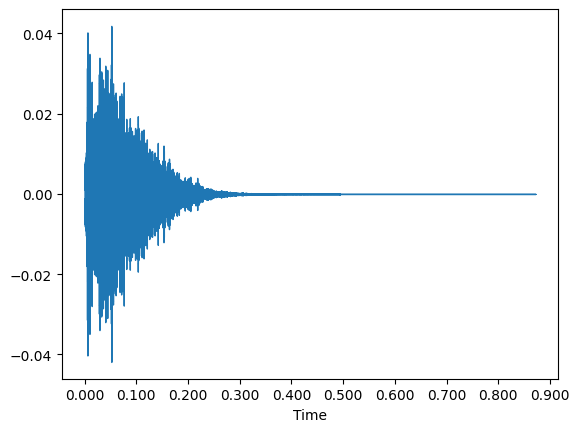

In [23]:
postproc_and_play_snare(images[1])

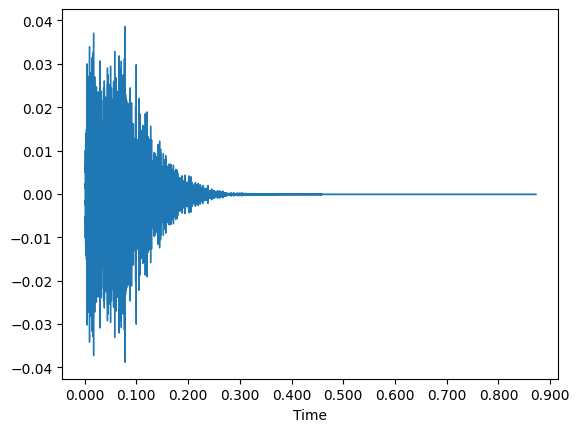

In [24]:
postproc_and_play_snare(images[2])

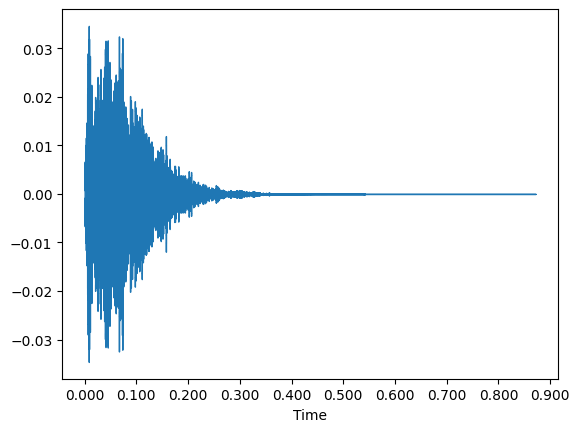

In [25]:
postproc_and_play_snare(images[3])

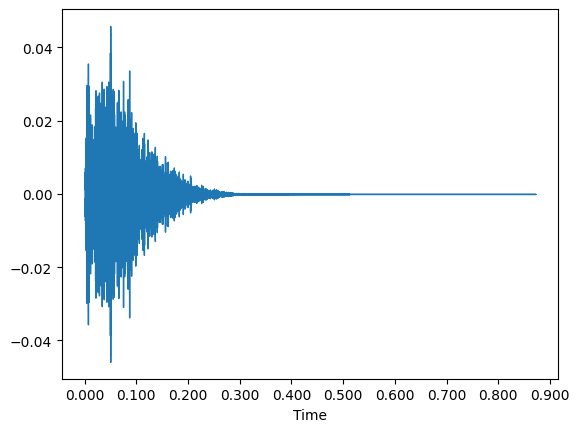

In [26]:
postproc_and_play_snare(images[4])

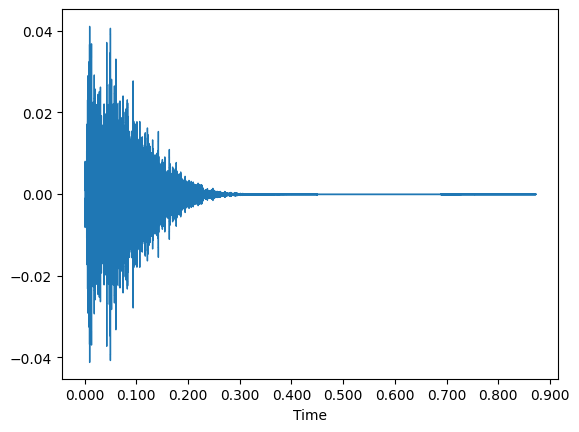

In [27]:
postproc_and_play_snare(images[5])

In [28]:
np.save('snares_100', images)